## Introduction:

- A few months ago deep fakes are in news for creating nuisance. So  I thought of it and tried to develop a model which will classify the Real and Fake faces present in test data provided.

**Things to look forward to:**

- Pretrained Model Integration.
- Model Accuracy and Loss Visualization.
- Confusion Matrix.
- Predictions on few images.



## Imports

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D
import keras
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from sklearn.metrics import confusion_matrix
import itertools
import os
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Using TensorFlow backend.


### Path Specification

In [2]:
import os

real = "../input/real-and-fake-face-detection/real_and_fake_face/training_real/"
fake = "../input/real-and-fake-face-detection/real_and_fake_face/training_fake/"
datadir = "../input/real-and-fake-face-detection/real_and_fake_face/"


real_path = os.listdir(real)
fake_path = os.listdir(fake)

### Let's take a closer look.

**1. Real Face**

In [3]:
def load_img(path):
    image = cv2.imread(path)
    image = cv2.resize(image, (224, 224))
#     print(labels)
    return image[...,::-1]

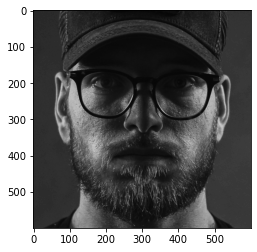

training_real


In [4]:
# datadir = "dataset"
categories = ["training_real" , "training_fake"]

for category in categories:
    path = os.path.join(datadir, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
        plt.imshow(img_array, cmap="gray")
        # plt.imshow(img_array, cmap= plt.cm.binary)
        plt.show()
        print(category)
        break
    break

### Creating Training Data

In [5]:
training_data = []
IMG_SIZE = 224

## This means 0 will indicate Real facial Images and 1 to Fake facial Images.

categories = ["training_real" , "training_fake"]

def create_training_data():
    for category in categories:
        path = os.path.join(datadir, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_UNCHANGED)
                new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
                training_data.append([new_array,class_num])
            except:
                pass
%time create_training_data()


CPU times: user 20.4 s, sys: 659 ms, total: 21 s
Wall time: 47.3 s


In [6]:
training_data = np.array(training_data)
print(training_data.shape)

(2041, 2)


### Building X(Features) and Y(Labels) for train test split.

### [np.random.shuffle(array)](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.shuffle.html)

- Shuffling here is important as the data is sequential therefore if directly fed into the network, the network just learn to give a single prediction and not on merit. 

In [7]:
import random

np.random.shuffle(training_data)
for sample in training_data[:10]:
    print(sample[1])

0
0
0
0
0
0
0
0
1
0


In [8]:
X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y = np.array(y)

In [9]:
print(X.shape)
print(y.shape)

(2041, 224, 224, 3)
(2041,)


In [10]:
print(np.unique(y, return_counts = True))
print(y[1:10])

(array([0, 1]), array([1081,  960]))
[0 0 0 0 0 0 0 1 0]


In [11]:
## Normalization 
X = X/255.0 


### [Train-Test Split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [12]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
print("Shape of test_x: ",X_train.shape)
print("Shape of train_y: ",y_train.shape)
print("Shape of test_x: ",X_test.shape)
print("Shape of test_y: ",y_test.shape)

Shape of test_x:  (1632, 224, 224, 3)
Shape of train_y:  (1632,)
Shape of test_x:  (409, 224, 224, 3)
Shape of test_y:  (409,)


In [14]:
print(y_test[1:10])

[1 0 0 0 0 1 0 0 1]


In [15]:
print(np.unique(y_train, return_counts = True))
print(np.unique(y_test, return_counts = True))

(array([0, 1]), array([858, 774]))
(array([0, 1]), array([223, 186]))


In [16]:
%time train_x = tf.keras.utils.normalize(X_train,axis=1)
%time test_x = tf.keras.utils.normalize(X_test, axis=1)

CPU times: user 705 ms, sys: 697 ms, total: 1.4 s
Wall time: 1.4 s
CPU times: user 176 ms, sys: 177 ms, total: 352 ms
Wall time: 351 ms


In [17]:
model = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(64,(3,3),activation = 'relu',
                            input_shape= X.shape[1:]),
            tf.keras.layers.Conv2D(64,(3,3),activation = 'relu'),
            tf.keras.layers.MaxPooling2D(2,2),
            tf.keras.layers.Conv2D(64,(3,3),activation = 'relu'),
            tf.keras.layers.Conv2D(64,(3,3),activation = 'relu'),
            tf.keras.layers.MaxPooling2D(2,2),
            tf.keras.layers.Dropout(0.25),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation=tf.nn.relu),
            tf.keras.layers.Dense(2, activation=tf.nn.softmax)

])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

%time hist = model.fit(X_train,y_train, batch_size=20, epochs = 6, validation_split=0.1)

Train on 1468 samples, validate on 164 samples
Epoch 1/6
1468/1468 [==============================] - 10s 7ms/sample - loss: 0.7269 - accuracy: 0.5198 - val_loss: 0.6940 - val_accuracy: 0.4878
Epoch 2/6
1468/1468 [==============================] - 6s 4ms/sample - loss: 0.6920 - accuracy: 0.5238 - val_loss: 0.6958 - val_accuracy: 0.4878
Epoch 3/6
1468/1468 [==============================] - 6s 4ms/sample - loss: 0.6884 - accuracy: 0.5640 - val_loss: 0.6792 - val_accuracy: 0.5854
Epoch 4/6
1468/1468 [==============================] - 6s 4ms/sample - loss: 0.6663 - accuracy: 0.6165 - val_loss: 0.6763 - val_accuracy: 0.5366
Epoch 5/6
1468/1468 [==============================] - 6s 4ms/sample - loss: 0.6232 - accuracy: 0.6594 - val_loss: 0.7046 - val_accuracy: 0.5122
Epoch 6/6
1468/1468 [==============================] - 6s 4ms/sample - loss: 0.5588 - accuracy: 0.7016 - val_loss: 0.8530 - val_accuracy: 0.5610
CPU times: user 29.3 s, sys: 5.05 s, total: 34.3 s
Wall time: 39.3 s


### Visualizing Training Loss and Accuracy.

- Credits : [Anuj Shah](https://github.com/anujshah1003/own_data_cnn_implementation_keras/blob/master/updated_custom_data_cnn.py)

- The code below is taken from the github repository of Anuj Shah. You can visit the link given to see any other details.

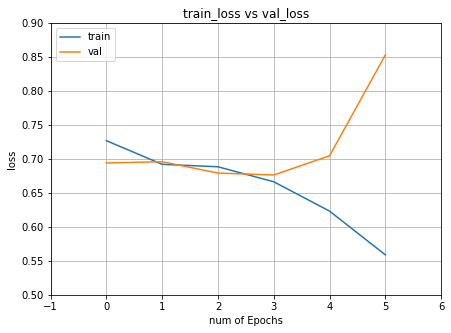

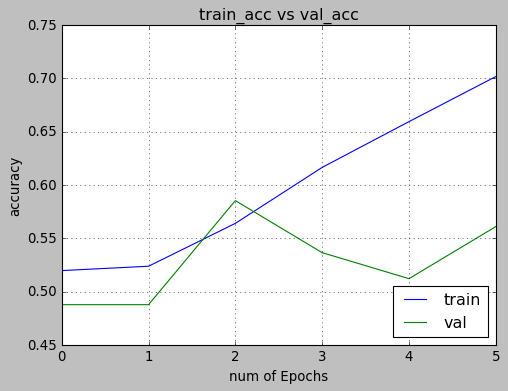

In [18]:
epochs = 6
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
xc = range(epochs)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

### Evaluation on Test Data

In [19]:
val_loss, val_acc = model.evaluate(X_test, y_test)
print(val_loss)
print(val_acc)

409/409 [==============================] - 1s 3ms/sample - loss: 0.8303 - accuracy: 0.5208
0.8302716561809437
0.5207824


### Predictions.

[[0.43174532 0.5682547 ]]


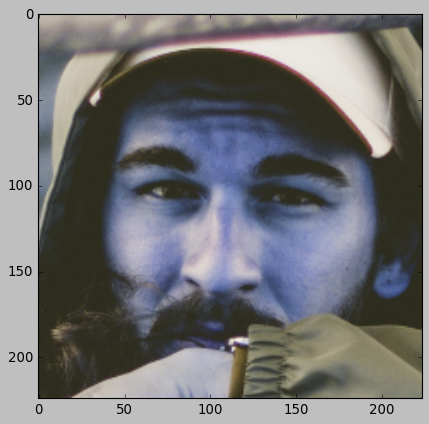

In [20]:
import random
n = random.randrange(100)
predictions = model.predict(X_test[[n]])
# predictions
print(predictions)
plt.imshow(X_test[n])

## [Confusion Matrix.](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html)

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

In [22]:
rounded_predictions = model.predict_classes(X_test)
cm = confusion_matrix(y_test,rounded_predictions)

In [23]:
def plot_confusion_matrix(cm, classes,
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[123 100]
 [ 96  90]]


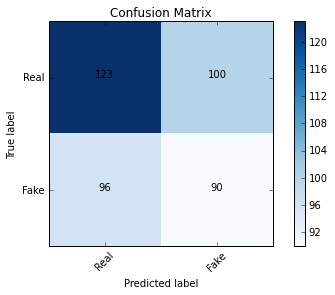

In [24]:
cm_plot_labels = ['Real', 'Fake']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

- This means our model predicted every single time and got the 54% accuracy.

In [25]:
model.save('serial.h5')